# Testing satpy

`satpy` is a Python package for processing meterological remote sensing data.  It combines readers, compositors, resampling tools and writers to perform most satellite image processing requirements.  See https://satpy.readthedocs.io/en/latest/overview.html for a more complete overview.

The main data structure is the `scene` class which is a container for `xarray.DataArray` objects.  `DataArrays` utilize `dask`, which enables out-of-memory computing for large data sets.

In this notebook, I focus on reading, displaying and resampling MODIS Level 1B top of atmosphere irradiances from the MOD02 product for the Arctic region.

In [1]:
import glob
import os
import datetime as dt
import warnings

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from satpy import Scene, find_files_and_readers
from satpy.writers import get_enhanced_image

from pyresample import geometry
from pyresample.ewa import ll2cr, fornav  # Might not be necessary if using satpy

To process files, both band irradiances (MOD02HKM) and geolocation (MOD03) data are required.  `satpy` has a utility `find_files_and_readers` to locate imagery from a given sensor for a given date range. 

```
myfiles = find_files_and_readers(base_dir=os.path.join(DATAPATH, 'MOD02HKM', '2015', '091'),
                                 sensor="modis",
                                 start_time=dt.datetime(2015, 4, 1, 11, 40),
                                 end_time=dt.datetime(2015, 4, 1, 12, 5),
                                 reader='modis_l1b')
```
However, there does not seem to be a way to locate both band data and geolocation data when they are in different locations.  So I use `glob` to do this.  We can then do this for a single image swath as follows.

In [2]:
DATAPATH = '/media/apbarret/stroeve_projects/modis_downloads'
mod02hkm_files = glob.glob(os.path.join(DATAPATH, 'MOD02HKM', '2015', '091', '*2015091.1110.*.hdf'))
geoloc_files = glob.glob(os.path.join(DATAPATH, 'MOD03', '2015', '091', '*2015091.1110.*.hdf'))
mod02hkm_files + geoloc_files

['/media/apbarret/stroeve_projects/modis_downloads/MOD02HKM/2015/091/MOD02HKM.A2015091.1110.061.2017320013156.hdf',
 '/media/apbarret/stroeve_projects/modis_downloads/MOD03/2015/091/MOD03.A2015091.1110.061.2017320012157.hdf']

The `scene` object, with geolocation data, is created as follows.  A `reader` inthis case `modis_l1b` must be provided so that `satpy` knows how to read the file structure.  For MODIS readers, `pyhdf` must be installed.  This is not a requirement for `satpy` so you may get an error if `pyhdf` is not already installed.  This ommission is easily remedied

```
conda install pyhdf
```

In [3]:
scene = Scene(reader='modis_l1b', filenames=mod02hkm_files + geoloc_files)

To work with data you must load it.  For MOD02 data, each HDF file contains multiple bands.  Here, I load bands 1, 4 and 3 (the MODIS channels to make an RGB).  I also request a __true_color__ composite.  This is not created when the data is first loaded.  I think, because a composite cannot be created from sawth data. 

In [4]:
scene.load(['1', '4', '3', 'true_color'])

The following datasets were not created and may require resampling to be generated: DatasetID(name='true_color', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)


To plot the data, I use `cartopy` and `matplotlib.pyplot.imshow`.  `satpy` also offers holoviews and geoviews to image display.  For `imshow`, we need to extent of the image.  There's some weirdness here that I haven't figured out.  Plotting the lon, lat arrays gives a sensible image extent.  Plotting band 1 using `imshow` with `img_extent` defined from the upper-left and lower-right coordinates from `lons` and `lats` or using the minimum and maximum of `lons` and `lats` gives different results.  

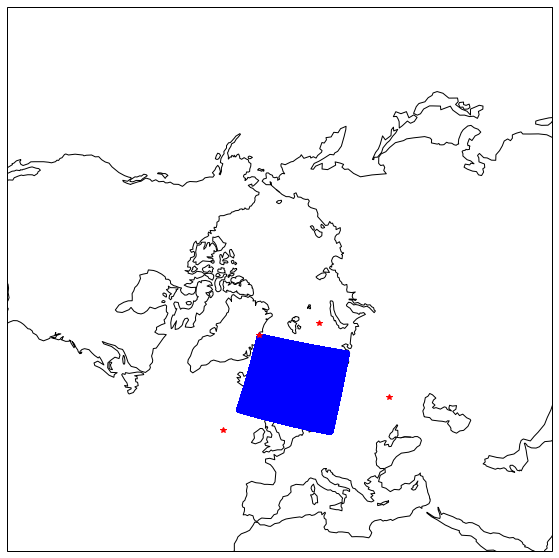

In [5]:
lons, lats = scene['1'].attrs['area'].get_lonlats()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lons = lons.compute()
    lats = lats.compute()
    
#img_extent = [lons[0,0], lons[-1,-1], lats[0,0], lats[-1,-1]]
img_extent = [np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)]

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 30., 90.], ccrs.PlateCarree())
ax.coastlines()
#ax.imshow(scene['1'], origin="upper", extent=img_extent, transform=ccrs.PlateCarree(), cmap='Greys');
ax.plot(lons, lats, 'b.', transform=ccrs.PlateCarree());
ax.plot(np.nanmin(lons), np.nanmin(lats), 'r*', transform=ccrs.PlateCarree())
ax.plot(np.nanmax(lons), np.nanmin(lats), 'r*', transform=ccrs.PlateCarree())
ax.plot(np.nanmin(lons), np.nanmax(lats), 'r*', transform=ccrs.PlateCarree())
ax.plot(np.nanmax(lons), np.nanmax(lats), 'r*', transform=ccrs.PlateCarree())

The `resample` method of `scene` can be used to resample the swath data to a grid.  `resample` requires an area definition and a resampling method.  Area definition may be a named area or an area definition defined using `pyresample.geometry.AreaDefinition`.  Here, I define the NSIDC EASE-Grid 2.0 North grid as the area and use the _Elliptical weighted averaging_ `ewa` resampling method. 

In [6]:
area_id = 'ease2_nh'
description = 'NSIDC EASE-Grid 2.0 North'
proj_id = 'ease2_nh'
projection = '+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'
width = 2500
height = 2500
extent = [-4500000.0, 4500000.0, 4500000.0, -4500000.0]
area_def = geometry.AreaDefinition(area_id, description, proj_id,
                                  projection,
                                  width, height, 
                                  extent)

The resampling is done below.  For starters, I use a simple nearest neighbour sampling method.  Ideally, I want to use the Elliptical Weighted Averaging method but I have not got this to work.

In [7]:
new_scn = scene.resample(area_def, resampler='nearest', nprocs=4)

/home/apbarret/anaconda3/envs/satpy/lib/python3.7/site-packages/pyproj/crs/crs.py:539: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
Could not calculate destination definition resolution
Could not calculate destination definition resolution


The resampled data is plotted below.  I've zoomed in on the image area.  The coastlines match and all looks pretty good.

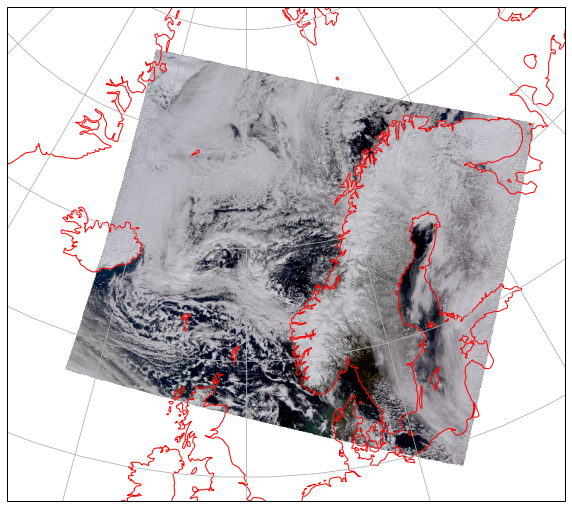

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    img = get_enhanced_image(new_scn['true_color']).pil_image()

new_scn_crs = new_scn['1'].attrs['area'].to_cartopy_crs()

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
#ax.set_extent([-180.,180.,30.,90.], ccrs.PlateCarree())
ax.set_extent([-1500000., 2000000., -4300000., -1200000.], ccrs.NorthPolarStereo())
ax.coastlines(resolution='50m', color='red')
ax.imshow(img, origin="upper",
          extent=new_scn_crs.bounds, transform=new_scn_crs)
ax.gridlines()

The resampled dataset can be saved as a GeoTiff.  The image can be saved as a png.

In [17]:
OUTPUT_DIR = '.'
dataset_fout = os.path.basename(mod02hkm_files[0]).replace('HKM',f'.{area_id}').replace('hdf', 'tif')
print(f'Writing resampled data to {os.path.join(OUTPUT_DIR,dataset_fout)}')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    new_scn.save_datasets(writer='geotiff', filename=dataset_fout, base_dir=OUTPUT_DIR)

Writing resampled data to ./MOD02.ease2_nh.A2015091.1110.061.2017320013156.tif


/home/apbarret/anaconda3/envs/satpy/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/apbarret/anaconda3/envs/satpy/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/apbarret/anaconda3/envs/satpy/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/home/apbarret/anaconda3/envs/satpy/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/home/apbarret/anaconda3/envs/satpy/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/home/apbarret/anaconda3/envs/satpy/lib/pyt

In [18]:
!gdalinfo MOD02.ease2_nh.A2015091.1110.061.2017320013156.tif

Driver: GTiff/GeoTIFF
Files: MOD02.ease2_nh.A2015091.1110.061.2017320013156.tif
Size is 2500, 2500
Coordinate System is:
PROJCS["unknown",
    GEOGCS["unknown",
        DATUM["Unknown_based_on_WGS84_ellipsoid",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            TOWGS84[0,0,0,0,0,0,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",90],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]
Origin = (-4500000.000000000000000,-4500000.000000000000000)
Pixel Size = (3600.000000000000000,3600.000000000000000)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_DATETIME=2015:04:01 11:10:00
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (-4500000.000,-4500000.000) ( 45d 0' 0.00"